In [7]:
from pathlib import Path
import json
from tqdm import tqdm
import sys
from multiprocessing import Pool

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("default")
WORK_DIR = Path().absolute()
sys.path.append(str(WORK_DIR.parent))

In [2]:
from energyvslatconst import energyvslatconst, equilibrate_graphene

In [3]:
# Read setting file
ROOT_DIR = WORK_DIR.parent
with open(ROOT_DIR / "settings.json", "r") as f:
    settings = json.load(f)
partition = settings["partition"]
RES_DIR = WORK_DIR / "results" / "dropout" / f"{partition}_partition"

In [4]:
# DFT data
dft_data = np.loadtxt("../energyvslatconst/dft_data.txt", delimiter=",")

In [20]:
##########################################################################################
# Bootstrap
# ---------
# Compute the energy ensembles
potential = "DUNN_best_train"
ainit = 2.466
alist = np.linspace(0.93, 1.09, 51) * ainit
preds_samples_file = RES_DIR / "uncertainty_energy_vs_latconst_graphene_refine.npz"
if preds_samples_file.exists():
    preds_data = np.load(preds_samples_file)
    energy_ensembles = preds_data["energy_ensembles"]
else:
    # energy_ensembles = np.empty((0, len(alist)))

    def energyvslatconst_wrapper(set_idx):
        return energyvslatconst(potential, alist, "graphene", set_idx + 1)[1]

    # for set_idx in tqdm(range(100)):
    #     # Predictions
    #     _, elist, _ = energyvslatconst(potential, alist, "graphene", set_idx + 1)
    #     energy_ensembles = np.row_stack((energy_ensembles, elist))
    with Pool(25) as p:
        energy_ensembles = list(
            tqdm(p.imap(energyvslatconst_wrapper, range(100)), total=100)
        )
    energy_ensembles = np.array(energy_ensembles).astype(float)
    # np.savez(preds_samples_file, alist=alist, energy_ensembles=energy_ensembles)

100%|███████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.82it/s]


In [25]:
energy_mean_do = np.mean(energy_ensembles, axis=0)
energy_error_do = np.std(energy_ensembles, axis=0)

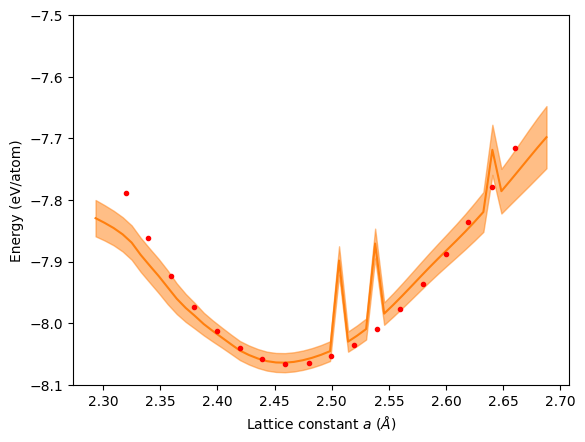

In [26]:
# Plot the result curves
# Energy vs lattice constant
plt.figure()
plt.plot(*(dft_data.T), "r.", zorder=10, label="DFT")

# Dropout
plt.fill_between(
    alist,
    energy_mean_do - energy_error_do,
    energy_mean_do + energy_error_do,
    alpha=0.5,
    color="tab:orange",
)
plt.plot(alist, energy_mean_do, "-", color="tab:orange", label="DUNN dropout")
plt.ylim(-8.1, -7.5)
plt.xlabel(r"Lattice constant $a$ $(\AA)$")
plt.ylabel("Energy (eV/atom)")
# plt.legend()

plt.show()
